In [1]:
import sys, platform, os
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower
import useful_functions as uf
import pysm3
from fgbuster import (CMB, Dust, Synchrotron, basic_comp_sep,get_observation, get_instrument, get_sky)
from fgbuster.visualization import corner_norm
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

nside_patch = 16
nside=16
nside_compsep=16#nside_patch

instrument = get_instrument('LiteBIRD')
kind_of_map='d0s0'

#sky_vary = get_sky(NSIDE_PATCH, kind_of_map)
sky_vary = get_sky(nside, kind_of_map)

'''for spectral_param in [sky_vary.components[0].mbb_index,
                       sky_vary.components[0].mbb_temperature,
                       sky_vary.components[1].pl_index]:
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param.value, nside_patch),
                                    nside) * spectral_param.unit
    print(spectral_param.unit)'''

unit=-3#-3 #uk->mk 
sync_freq_maps = get_observation(instrument, sky_vary, noise=False, nside=nside,unit='mK_CMB') #, unit='uK_CMB')
print(sync_freq_maps[0])

/home/amorelli/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


[[ 1.14667974e-02  1.00148963e-02  1.15785319e-02 ...  1.35583645e-02
   1.33368587e-02  1.33860083e-02]
 [-1.12159725e-03  3.07047922e-05 -5.03066520e-04 ...  1.02486555e-03
  -1.10538700e-03  8.42908339e-04]
 [-7.60052353e-04  1.14238507e-03 -6.24887587e-04 ...  1.67781400e-04
   3.67922388e-04 -8.91877979e-04]]


In [2]:
seed_test=70
np.random.seed(seed_test)# i set a seed for the generation of the maps and the a_lm. I use a seed for reproducibility.

n_maps=10
n_channels=1
pol=2

sensitivities=instrument["depth_p"]

n_freq=len(sensitivities)
n_pix=hp.nside2npix(nside)

r=np.ones(1)*0.01
data=uf.generate_cl(n_spectra=1,Nside=512,Nside_red=nside,tau_interval=[0.06,0.06],r_interval=[0.01,0.01], raw=False)

beam_w=2*hp.nside2resol(nside, arcmin=False)

components = [CMB(), Dust(150.), Synchrotron(20.)]

# The starting point of the fit is the pysm default value, so let's shift it
#components[1].defaults = [1.6, 22.]
#components[2].defaults = [-2.7]

noise_maps=np.ones(shape=(n_freq,n_maps,n_pix,n_channels*pol))
#noise_maps_T=np.ones(shape=(n_freq,n_maps,n_pix,n_channels))
for i,s in enumerate(sensitivities):
    corr=np.sqrt(2)
    noise=uf.generate_noise_maps(n_maps,n_channels,nside,pol=2,sensitivity=s*corr)#if i consider half of the execution time the error increases
    #you can prove it using S/N formula
    #noise_T=uf.generate_noise_maps(n_maps,n_channels,nside,pol=1, sensitivity=s*corr/np.sqrt(2))
    noise_maps[i]=noise
    #noise_maps_T[i]=noise_T

noise=noise_maps[0]*0.0
#noise_T=noise_maps_T[0]*0.0

maps_per_cl_gen=uf.maps_per_cl(distribution=0)
maps_per_cl=maps_per_cl_gen.compute_maps_per_cl(r,n_train=n_maps,n_train_fix=n_maps)

QU_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, map_per_cl=maps_per_cl, 
                         noise_maps=noise, beam_w=beam_w, kind_of_map="QU", raw=1, n_channels=n_channels, beam_yes=1 , verbose=0)[0]
#T_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, map_per_cl=maps_per_cl, 
                         #noise_maps=noise_T, beam_w=beam_w, kind_of_map="TT", raw=1, n_channels=n_channels, beam_yes=1 , verbose=0)[0]

freq_maps=np.ones(shape=(n_channels,n_maps,n_freq,pol,n_pix)) #comp_sep wants n_channels as first dimension, also i cannot
#put polarization in the n_channel dimension -> i break my conventions
#freq_maps=np.ones(shape=(n_channels,n_maps,n_freq,3,n_pix))
for i in range(n_maps):
    for j in range(n_freq):
        # freq_maps[j,i,0]=noise_maps_T[i,j]+sync_freq_maps[i,0]+T_maps[j,:,0]
        # freq_maps[j,i,1]=noise_maps[i,j]+sync_freq_maps[i,1]+QU_maps[j,:,0]
        # freq_maps[j,i,2]=noise_maps[i,j]+sync_freq_maps[i,2]+QU_maps[j,:,1]
        for k in range(n_channels):
            #freq_maps[k,i,j,0,:]=noise_maps_T[j,i,:,k]*10**unit+sync_freq_maps[j,0]+T_maps[i,:,k]*10**unit
            freq_maps[k,i,j,0,:]=noise_maps[j,i,:,k*n_channels]*10**unit+sync_freq_maps[j,1]+QU_maps[i,:,k*n_channels]*10**unit
            freq_maps[k,i,j,1,:]=noise_maps[j,i,:,k*n_channels+1]*10**unit+sync_freq_maps[j,2]+QU_maps[i,:,k*n_channels+1]*10**unit

result = np.ones(shape=(n_maps,n_pix,n_channels*pol))
#result = np.ones(shape=(n_maps,3,n_pix))
import time
start_time = time.time()
for i in range(n_maps):
    for k in range(n_channels):
        compsep_tot=basic_comp_sep(components, instrument, freq_maps[k,i],nside=nside_compsep) #nside=0 is default
        compsep=compsep_tot.s[0]
        for p in range(pol):
            result[i,:,k*pol+p]=compsep[p]-QU_maps[i,:,k*pol+p]*10**unit
print("--- %s seconds ---" % (time.time() - start_time))

--- 176.6605498790741 seconds ---


In [3]:
result*=10**-unit
res=hp.nside2resol(nside, arcmin=True)
mean_Q=np.mean(result[0,:,0])
std_Q=np.std(result[0,:,0])
sensitivity_Q=std_Q*res
print(mean_Q,std_Q,sensitivity_Q)
mean_U=np.mean(result[0,:,1])
std_U=np.std(result[0,:,1])
sensitivity_U=std_U*res
print(mean_U,std_U,sensitivity_U)

-0.0004826107090292211 0.05253676364779643 11.551317608503506
-0.0006023682747203898 0.03956037089332289 8.698183465629928


In [4]:
mean_map_Q=np.zeros(n_pix)
sigma_map_Q=np.zeros(n_pix)
mean_map_U=np.zeros(n_pix)
sigma_map_U=np.zeros(n_pix)
for i in range(n_pix):
    mean_map_Q[i]=np.mean(result[:,i,0])
    sigma_map_Q[i]=np.std(result[:,i,0])
    mean_map_U[i]=np.mean(result[:,i,1])
    sigma_map_U[i]=np.std(result[:,i,1])

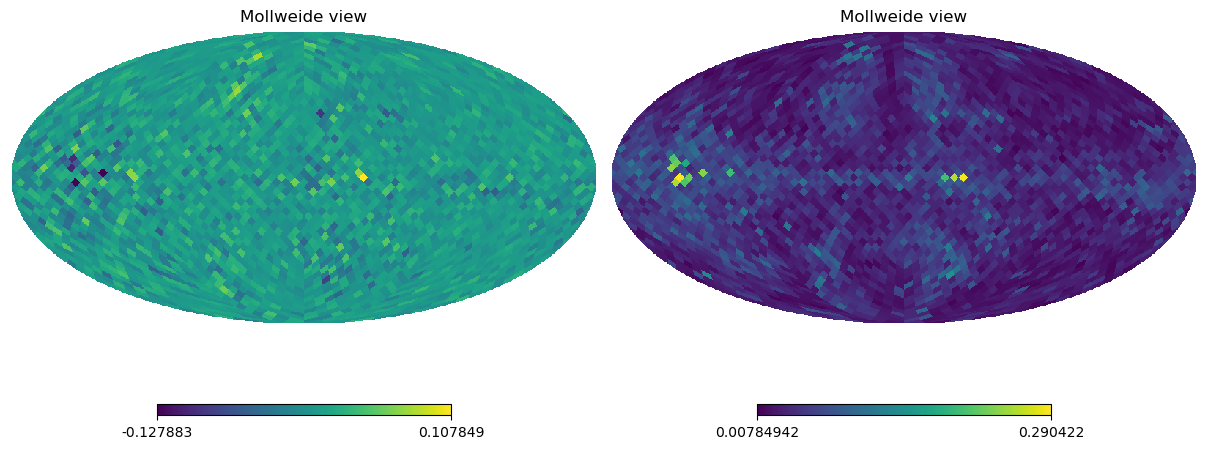

In [5]:
hp.mollview(mean_map_Q,sub=(1,2,1))#,min=-0.01,max=0.01)
hp.mollview(sigma_map_Q,sub=(1,2,2))#,min=0.02,max=0.03)

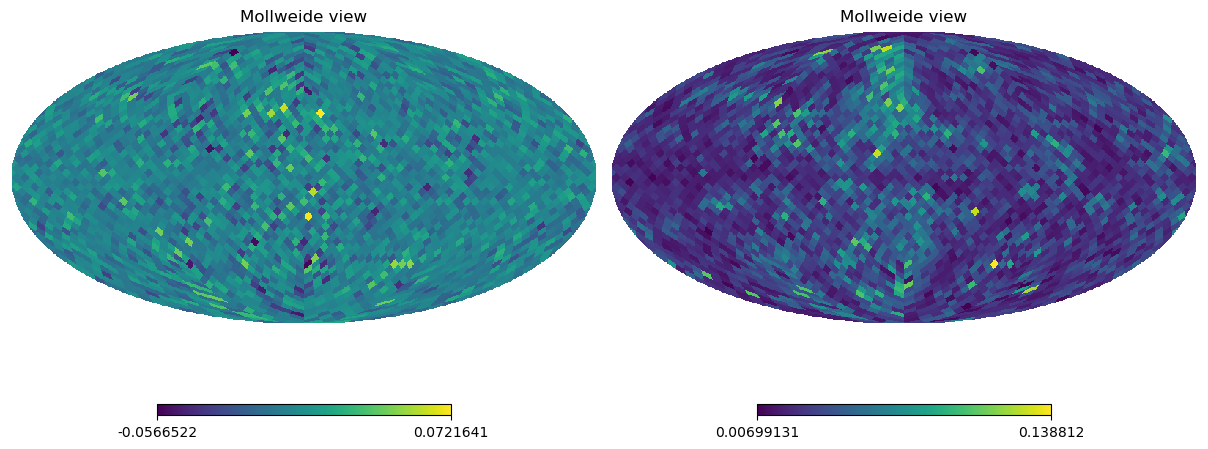

In [6]:
hp.mollview(mean_map_U,sub=(1,2,1))#,min=-0.01,max=0.01)
hp.mollview(sigma_map_U,sub=(1,2,2))#,min=0.02,max=0.03)